# TOV Emulator to train a NN to predict mass and radius of a Neutron Strar from a Neuclear EOS

### <div style= 'color: goldenrod'> Import all the required modules

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import numpy as np
import matplotlib.pyplot as plt
from numpy import pi as pi
from scipy.integrate import odeint
import torch
import torch.nn as nn
import torch.optim as optim
import time # to meaasure execution time of code blocks
from torch.utils.data import TensorDataset, DataLoader


# Custom modules
import eos # generates EOS tables. Returns energy density, pressure, etc. for given set of EOS parameters. 
import tov # solves TOV equations and returns mass and radius for a given EOS and central pressure
import tov_tide # solves TOV equations including tidal deformability calculations, for neutron star tidal effects in binaries.


%matplotlib widget

### <div style= 'color: slateblue'> Custom module:  eos

In [ ]:
# eos.eos?

# Parameters:
# ----------

# al_in: Slope of symmetry energy
# aksym_in: Curvature of symetry energy 
# rho1_in:                  # are density breakpoints in the piecewise polytropic EOS. 
# rho2_in:                  # Each rho corresponds to a density where the polytropic index changes.
# rho3_in:                  
# gamma1:                   # are polytropic indices in each density segment.
# gamma2:                   # Controls how pressure scales with density in each segment: 
# gamma3:                   # 𝑃 ∝ 𝜌^𝛾


# Returns:
# -------

# icount: number of valid points in the returned arrays.
# rnb: baryon number density array
# pres: pressure at each density point array
# ener: energy density at each density point array
# cs2: speed of sound array
# iflag: flag if EOS is causal or monotonic

### <div style= 'color: slateblue'> Custom module:  tov

In [ ]:
# tov.tov?

# Parameters:
# ----------

# e: energy density array from EOS
# p: pressure values array from EOS
# pc: central pressure


# Returns:
# -------

# m: gravitational mass of the star in solar masses
# r: radius of the star in kms

### <div style= 'color: slateblue'> Custom module:  tov_tide

In [ ]:
# tov_tide?

# Parameters:
# ----------

# e: energy density array from EOS
# p: pressure values array from EOS
# pc: central pressure


# Returns:
# -------

# m: gravitational mass of the star in solar masses
# r: radius of the star in kms
# lambda: 

### <div style= 'color: goldenrod'> Define the following functions:
$EoS(\theta)$:
Generate the energy density and pressure arrays for a given EOS parameter set.

$find\_first\_maxima$:
Find first local maxima (to get NS mass)

$get\_MR\_pc$:
Solve TOV equations to get mass-radius points for an array of central pressures.

$get\_MRL\_pc$:
Solve TOV equations to get mass, radius and tidal deformability points for an array of central pressures.

In [2]:
dkm = 1.3234e-6 # conversion of energy density and pressure from Mev/fm^3 to km^-2
conv = 197.33**3 # MeV/fm3 is roughly h_bar * c in natural units
pcmin = 1.33e-6 # Fiducial minimum central pressure used when generating neutron star sequences
                # Ensures TOV solver starts with a non-zero pressure 


def EoS(θ):
    """
    Generate the energy density and pressure arrays for a given EOS parameter set.
    Returns Energy and pressure array given given eos parameters and if eos is not montonic returns nan.
    
    Parameters:
    ----------
    θ = [L0, Ksym]: parameters of the nuclear EOS.
            
            L0: slope of symmetry energy. Controls how neutron-rich matter pressure grows with density.
            Ksym: curvature of symmetry energy. Determines how “stiff” the EOS is for neutron-rich matter at higher densities.
    
    Returns:
    -------
    nb: baryon number density array
    ener: energy density at each density point array
    pres: pressure at each density point array
    cs: speed of sound array
    icc: flag if EOS is causal or monotonic

    """
    L0, Ksym = θ[0], θ[1]
    # Calling the eos.eos module
    index, nb, pressure, energy, cs, icc = eos.eos(L0, Ksym, 1.6, 3.0, 6.2, 3.7, 2.4, 2.6)
    # Truncate arrays up to index-1 to ensure valid, monotonic EOS.
    nb = nb[0:index-1] 
    pressure = pressure[0:index-1]
    energy = energy[0:index-1]
    cs = cs[0:index-1]
    # Converts pressure and energy to km^-2 units
    pres = pressure * dkm
    ener = energy * dkm
    return ener, pres, nb, cs, icc

################################################################################

def get_MR_pc(θ, pc):
    """
    Solve TOV equations to get mass-radius points for an array of central pressures.

    Parameters:
    ----------
    θ: [L0, Ksym] EOS parameters
    pc: array of entral pressures

    Returns:
    -------
    M: List of Masses
    R: List of Radiuses corresponding to each central pressure

    """
    M=[]
    R=[]
    for i in pc:
        L0, Ksym = θ[0], θ[1]
        # Calling the eos.eos module
        index, nb, pressure, energy, cs, icc = eos.eos(L0, Ksym, 1.6, 3.0, 6.2, 3.7, 2.4, 2.6)
        pressure = pressure[0:index-1]
        energy = energy[0:index-1]
        pres = pressure * dkm
        ener = energy * dkm
        # Calling the tov.tov module
        m, r = tov.tov(ener, pres, [i])
        M.append(m)
        R.append(r)
    return M, R
    
################################################################################

def get_MRL_pc(θ, pc):
    """
    Solve TOV equations to get mass, radius and tidal deformability points for an array of central pressures.

    Parameters:
    ----------
    θ: [L0, Ksym] EOS parameters
    pc: array of central pressures

    Returns:
    -------
    M: List of Masses
    R: List of Radiuses 
    L: List of Tidal deformabilities corresponding to each central pressure
    """
    M=[]
    R=[]
    L=[]
    for i in pc:
        L0, Ksym = θ[0] ,θ[1]
        # Calling the eos.eos module
        index, nb, pressure, energy, cs, icc = eos.eos(L0, Ksym, 1.6, 3.0, 6.2, 3.7, 2.4, 2.6)
        pressure = pressure[0:index-1]
        energy = energy[0:index-1]
        pres = pressure * dkm
        ener = energy * dkm
        # Calling the tov_tide.tov_tide module
        m, r, td = tov_tide.tov_tide(ener, pres, [i])
        M.append(m)
        R.append(r)
        L.append(td)
    return M, R, L

################################################################################

def find_first_maxima(arr):
    """
    Identify the first peak in a 1D array (used to find maximum neutron star mass).
    Loops through array to check if an element is larger than its neighbors → first local maximum.
    If no local maxima found, returns global maximum as fallback.

    Parameters:
    ----------
    arr: mass array

    Returns:
    -------
    max_index: index of the first maxima
    arr[max_index]: mass value of the first maxima

    """
    for i in range(1, len(arr) - 1):
        if arr[i] > arr[i - 1] and arr[i] > arr[i + 1]:
            return i, arr[i]  # Return the index and the value of the first maxima
    max_index = np.argmax(arr)
    return max_index, arr[max_index]

### <div style= 'color: goldenrod'> Mass-Radius relation for a single EOS of a Neutron Star

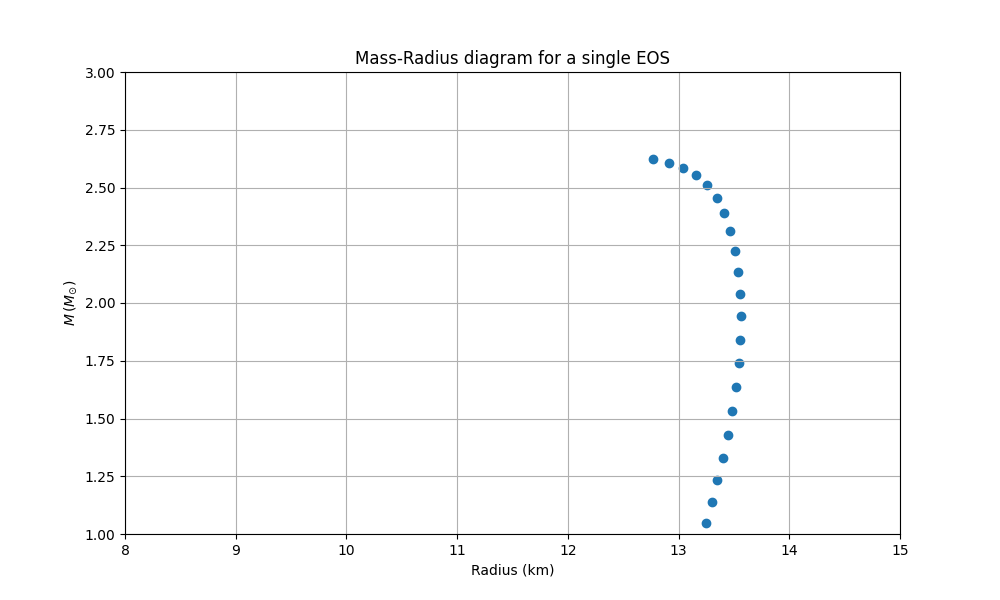

In [3]:
pcmin = 1.33e-6

L = 70
Ksym = 100
num_points = 50

ee, pp, nb, cs, icc = EoS([L, Ksym])

if icc == 0 and max(pp) > pcmin:
    # Create pressure grid
    pc_array = np.logspace(np.log10(pcmin), np.log10(max(pp)), num_points)
    
    # Calculate original mass and radius using TOV
    M_single, R_single = get_MR_pc([L, Ksym], pc_array)

    # Convert to NumPy arrays for element-wise operations
    M_single = np.array(M_single)
    R_single = np.array(R_single)

    # Find first maxima in mass array
    j, mmax = find_first_maxima(M_single)

    M_single = M_single[:j]
    R_single= R_single[:j]

plt.figure(figsize=(10,6))
plt.scatter(R_single, M_single)
plt.ylim(1,3)
plt.xlim(8,15)
plt.xlabel('Radius (km)')
plt.ylabel(r'$M \, (M_{\odot})$')
plt.title("Mass-Radius diagram for a single EOS")
plt.grid()
plt.show()

### <div style= 'color: slateblue'> Generate a dataset of 1000 different EOS that gives M,R,L values for a given set of EOS params (θ=[L0, Ksym]) and log_pc

In [ ]:
t1 = time.time()

# Number of EOS samples
num_samples = 5000

# Sample EOS parameters (L, Ksym)
EOS_params_all = np.random.uniform(low=[30., -400.],        # Generates a (1000, 2) array of random EOS parameters:
                                   high=[80., 100.],        # L sampled from [30, 80] and Ksym sampled from [-400, 100]
                                   size=(num_samples, 2))   # Each row = one EOS parameter pair [L, Ksym].

# Placeholders
MRL_data = []
log_pc_samples = []
valid_EOS_params = []

for i in range(num_samples):
    L, Ksym = EOS_params_all[i]
    ee, pp, nb, cs, icc = EoS([L, Ksym])
    if icc == 0 and max(pp) > pcmin: # if icc is 0 the EOS is monotonic and valid.
        # Check if EOS supports at least one star with central pressure above pcmin (otherwise no neutron star can be constructed)

        # Create pressure grid
        pc = np.logspace(np.log10(pcmin), np.log10(max(pp)), 50)
        pc[-1] = max(pp)
        # Create 50 logarithmically spaced central pressures from pcmin to max(pp)
        
        # Get mass, radius, and tidal deformability
        m, r, td = get_MRL_pc([L, Ksym], pc) 

        # Convert to NumPy arrays for element-wise operations
        m = np.array(m)
        r = np.array(r)
        td = np.array(td)

        # Find first maxima in mass array
        j, mmax = find_first_maxima(m)
        
        # Slice pc, m, r, td up to index j because past this point, stars are unstable
        # (inclusive or exclusive depending on your needs)
        pc = pc[:j+1]
        M = m[:j+1]
        R = r[:j+1]
        TD = td[:j+1]
            
        if not (np.any(np.isnan(M)) or np.any(np.isnan(R)) or np.any(np.isnan(TD))): # Skip any result with NaNs
            log_pc_samples.append(np.log10(pc))          # full array of shape (j+1,)
            valid_EOS_params.append(np.tile([L, Ksym], (len(pc), 1)))  # repeat L,Ksym for each pc point
            MRL_data.append(np.vstack([M, R, TD]).T)      # shape (j+1, 3), rows = points, cols = M,R,TD


# Stack all data into unified arrays
valid_EOS_params = np.vstack(valid_EOS_params)     # shape: (total_points, 2)
log_pc_samples = np.concatenate(log_pc_samples)    # shape: (total_points,)
MRL_data = np.vstack(MRL_data)                     # shape: (total_points, 3)


# Save stacked arrays
file_loc = "/home/kay/ML-for-Neutron-Stars/COMMA_emulator/Outputs-Kay/Models/"
file_name = f"EOS_dataset_{num_samples}samples.npz"

np.savez(file_loc+file_name,
         log_pc_samples = log_pc_samples,
         valid_EOS_params = valid_EOS_params,
         MRL_data = MRL_data)

print("✅ Saved EOS_dataset.npz with shape:")
print("  log_pc_samples:", log_pc_samples.shape)
print("  valid_EOS_params:", valid_EOS_params.shape)
print("  MRL_data:", MRL_data.shape)

✅ Saved EOS_dataset.npz with shape:
  log_pc_samples: (230053,)
  valid_EOS_params: (230053, 2)
  MRL_data: (230053, 3)


### <div style= 'color: yellow'> Load the generated dataset, normalizing it and splitting into training and validation datasets

In [4]:
import pandas as pd
import re

num_samples = 1000 #############################################################

# Load dataset saved with np.savez
dataset_name = f"EOS_dataset_{num_samples}samples.npz"
dataset_loc = "/home/kay/ML-for-Neutron-Stars/COMMA_emulator/Outputs-Kay/Datasets/"
data = np.load(dataset_loc+dataset_name)

# Extract columns
log_pc_samples = data['log_pc_samples']     # shape: (N,)
valid_EOS_params = data['valid_EOS_params'] # shape: (N, 2)
MRL_data = data['MRL_data']                 # shape: (N, 3)

# Visualizing the dataset
df = pd.DataFrame(
    np.column_stack([log_pc_samples, valid_EOS_params, MRL_data]),
    columns=["log_pc", "L", "Ksym", "Mass", "Radius", "TidalDeformability"]
)
n = int(re.search(r"\d+", dataset_name).group())
print(f"Dataset preview with {n} samples:")
print(df.head(10))  # nicely formatted table of the first 10 values

# Prepare X (features) and y (targets)
X_eos = torch.tensor(np.column_stack([log_pc_samples, valid_EOS_params]), dtype=torch.float32)  # pc, L, Ksym
y_eos = torch.tensor(MRL_data[:, :2], dtype=torch.float32)  # Mass, Radius (target)

# Normalize the dataset
X_eos_mean, X_eos_std = X_eos.mean(dim=0), X_eos.std(dim=0)
y_eos_mean, y_eos_std = y_eos.mean(dim=0), y_eos.std(dim=0)
X_eos_norm = (X_eos - X_eos_mean) / X_eos_std
y_eos_norm = (y_eos - y_eos_mean) / y_eos_std

# Split into training and validation sets
train_size = int(0.8 * len(X_eos_norm))
X_eos_train, X_eos_val = X_eos_norm[:train_size], X_eos_norm[train_size:]
y_eos_train, y_eos_val = y_eos_norm[:train_size], y_eos_norm[train_size:]

# Convert data to PyTorch tensors
X_eos_train, y_eos_train = X_eos_train.view(-1, 3), y_eos_train.view(-1, 2)
X_eos_val, y_eos_val = X_eos_val.view(-1, 3), y_eos_val.view(-1, 2)

Dataset preview with 1000 samples:
     log_pc          L       Ksym      Mass     Radius  TidalDeformability
0 -5.876148  58.694477  10.576015  0.098653  69.920286        3.214959e+09
1 -5.814806  58.694477  10.576015  0.105419  45.475846        3.927776e+08
2 -5.753463  58.694477  10.576015  0.114403  33.544300        1.194948e+08
3 -5.692121  58.694477  10.576015  0.125518  26.768894        5.534953e+07
4 -5.630778  58.694477  10.576015  0.138802  22.545374        2.997355e+07
5 -5.569436  58.694477  10.576015  0.154310  19.748377        1.727188e+07
6 -5.508093  58.694477  10.576015  0.172184  17.809922        1.022104e+07
7 -5.446751  58.694477  10.576015  0.192556  16.425164        6.129059e+06
8 -5.385408  58.694477  10.576015  0.215581  15.414005        3.716365e+06
9 -5.324065  58.694477  10.576015  0.241471  14.664074        2.263645e+06


### <div style= 'color: yellow'> Defining and training the NN

In [5]:
# Set model number for saving
Model_num = "Model6" ###########################################################

In [6]:
# Define Neural Network for EOS predictions
class HybridPP_EOS_NN(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=100, output_dim=2): #############
        super(HybridPP_EOS_NN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1) # Dropout layer for regularization

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        return self.fc3(x)

Epoch [100/10000],
              Training Loss: 0.0193,
              Validation Loss: 0.0110
Epoch [200/10000],
              Training Loss: 0.0110,
              Validation Loss: 0.0046
Epoch [300/10000],
              Training Loss: 0.0077,
              Validation Loss: 0.0030
Epoch [400/10000],
              Training Loss: 0.0069,
              Validation Loss: 0.0024
Epoch [500/10000],
              Training Loss: 0.0052,
              Validation Loss: 0.0046
Epoch [600/10000],
              Training Loss: 0.0052,
              Validation Loss: 0.0014
Epoch [700/10000],
              Training Loss: 0.0052,
              Validation Loss: 0.0014
Epoch [800/10000],
              Training Loss: 0.0048,
              Validation Loss: 0.0023
Epoch [900/10000],
              Training Loss: 0.0045,
              Validation Loss: 0.0005
Epoch [1000/10000],
              Training Loss: 0.0050,
              Validation Loss: 0.0008
Epoch [1100/10000],
              Training Loss: 0.0049,
  

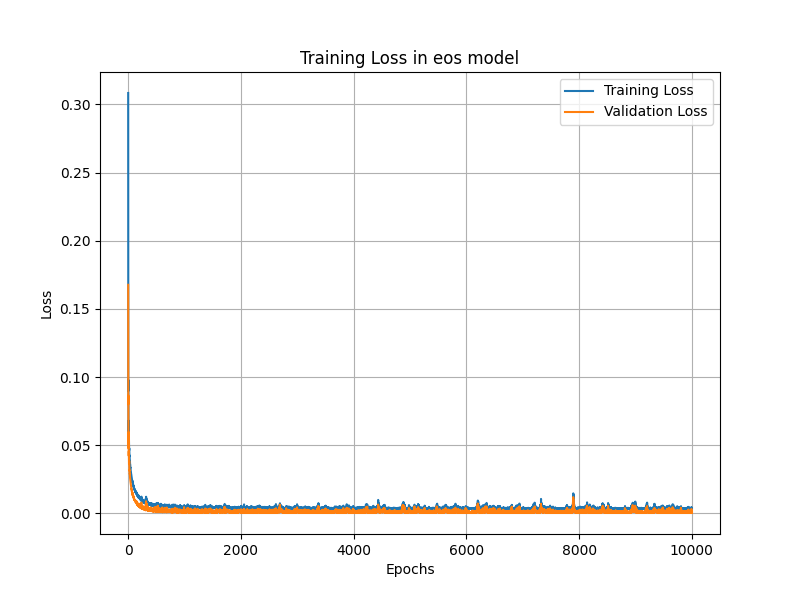

In [7]:
# Initialize and train the model
model_eos = HybridPP_EOS_NN()
criterion = nn.HuberLoss(delta=1.0)
optimizer = optim.Adam(model_eos.parameters(), lr=0.01) #######################

start_time = time.time()

epochs = 10000 #################################################################
training_losses = []
val_losses = []

best_val_loss = float('inf')
patience = 500  # Number of epochs to wait for improvement before stopping
patience_counter = 0

# # Batching the data
# batch_size = 16  ###############################################################

# train_dataset = TensorDataset(X_eos_train, y_eos_train)
# val_dataset = TensorDataset(X_eos_val, y_eos_val)

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size)

# for epoch in range(epochs):
#     model_eos.train()
#     epoch_train_loss = 0
#     for X_batch, y_batch in train_loader:
#         optimizer.zero_grad()
#         outputs = model_eos(X_batch)
#         loss = criterion(outputs, y_batch)
#         loss.backward()
#         optimizer.step()
#         epoch_train_loss += loss.item() * X_batch.size(0)
#     training_losses.append(epoch_train_loss / len(train_loader.dataset))

#     # Validation
#     model_eos.eval()
#     epoch_val_loss = 0
#     with torch.no_grad():
#         for X_batch, y_batch in val_loader:
#             val_outputs = model_eos(X_batch)
#             val_loss = criterion(val_outputs, y_batch)
#             epoch_val_loss += val_loss.item() * X_batch.size(0)
#     val_losses.append(epoch_val_loss / len(val_loader.dataset))

# Without batching (original code)
for epoch in range(epochs):
    # Training
    model_eos.train() # Training mode
    optimizer.zero_grad() # Erase the record of gradients
    outputs = model_eos(X_eos_train) # Forward pass
    loss = criterion(outputs, y_eos_train) # Compute training loss
    loss.backward() # Backward propogate the training loss
    optimizer.step()
    training_losses.append(loss.item())

    # Validation
    model_eos.eval() # Validation mode
    with torch.no_grad():
        val_outputs = model_eos(X_eos_val)
        val_loss = criterion(val_outputs, y_eos_val)
        val_losses.append(val_loss.item())

    # # Early stopping check
    # if val_loss.item() < best_val_loss:
    #     best_val_loss = val_loss.item()
    #     patience_counter = 0
    #     # Save the best model weights
    #     best_model_state = model_eos.state_dict()
    # else:
    #     patience_counter += 1
    #     if patience_counter >= patience:
    #         print(f"Early stopping at epoch {epoch+1}")
    #         break

    # Print progress every 100 epochs
    if (epoch + 1) % 100 == 0: 
        print(f"""Epoch [{epoch + 1}/{epochs}],
              Training Loss: {loss.item():.4f},
              Validation Loss: {val_loss.item():.4f}""")

end_time = time.time()
training_time = end_time - start_time

# # Restore best model
# model_eos.load_state_dict(best_model_state)
# print(f"Training finished. Best validation loss: {best_val_loss:.4f}")

# Plot Training Loss
plt.figure(figsize=(8, 6))
plt.plot(training_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss in eos model")
plt.grid()

fig_loc = "/home/kay/ML-for-Neutron-Stars/COMMA_emulator/Outputs-Kay/Models/"
fig_name = f"{Model_num}_Losses.png"
plt.savefig(fig_loc+fig_name, dpi=300, bbox_inches='tight')

plt.show()

### <div style= 'color: goldenrod'> Save trained model

In [ ]:
# Save trained model
network_loc = "/home/kay/ML-for-Neutron-Stars/COMMA_emulator/Outputs-Kay/Models/"
network_name = f"{Model_num}_hybridPP_nn.pth"
torch.save(model_eos.state_dict(), network_loc+network_name)

### <div style= 'color: goldenrod'> Save model details to a text file

In [ ]:
file_loc = "/home/kay/ML-for-Neutron-Stars/COMMA_emulator/Outputs-Kay/Models/"
file_name = Model_num+"_details.txt"

with open(file_loc + file_name, "w") as f:
    f.write(f"{Model_num} DETAILS\n\n")
    f.write("Number of dimensions:\n")
    f.write(f"input_dims: {model_eos.fc1.in_features}\n")
    f.write(f"hidden_dims: {model_eos.fc1.out_features}\n")
    f.write(f"output_dims: {model_eos.fc3.out_features}\n\n")
    f.write(f"Number of samples: {num_samples}\n\n")
    f.write(f"epochs: {epochs}\n\n")
    f.write(f"delta of criterion: {criterion.delta}\n\n")
    f.write(f"optimizer: Adam\n\n")
    f.write(f"learning rate: {optimizer.param_groups[0]['lr']}\n\n")
    f.write(f"Training stopped at epoch: {epoch+1}\n")
    f.write(f"training_time_seconds: {training_time:.2f}\n")
    f.write(f"Best validation loss: {best_val_loss:.4f}\n\n")

### <div style= 'color: slateblue'> Loading a trained model

In [11]:
Model_num = "Model2" 

# Instantiate the model class
model_eos = HybridPP_EOS_NN()
# Load the saved state dict
model_eos.load_state_dict(torch.load(f"/home/kay/ML-for-Neutron-Stars/COMMA_emulator/Outputs-Kay/Models/{Model_num}_hybridPP_nn.pth"))
# Set the model to evaluation mode
model_eos.eval()  

HybridPP_EOS_NN(
  (fc1): Linear(in_features=3, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
)

### <div style= 'color: yellow'>Model Evaluation and comparison on Testing (unseen) data

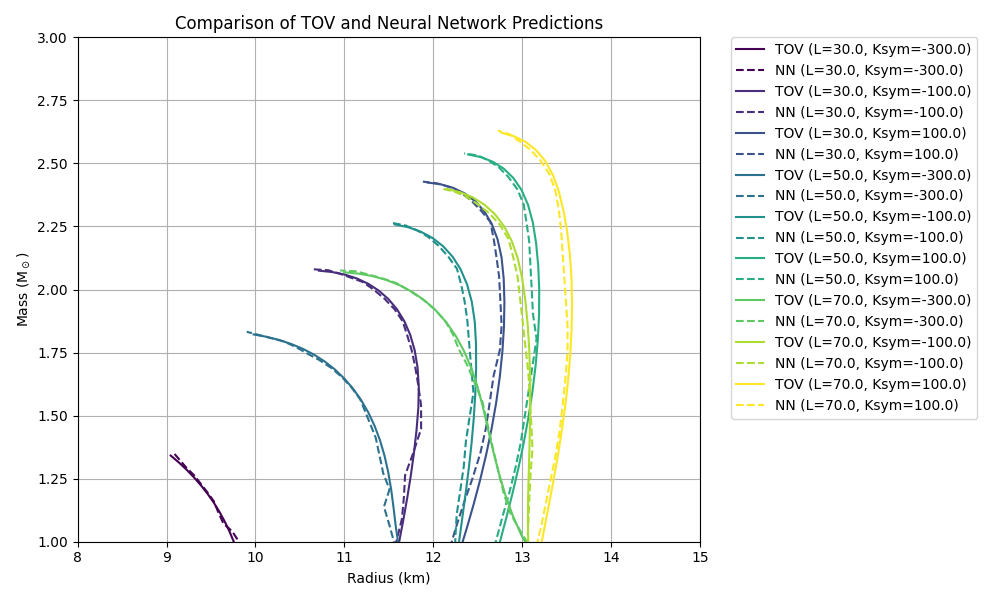

In [ ]:
num_points = 50
# Prepare ranges for L and Ksym
L_values = [30., 50., 70.]  
Ksym_values = [-300., -100., 100.]  

# Initialize lists to store results
predicted_mass = []
predicted_radius = []
original_mass = []
original_radius = []

# Iterate over all L and Ksym values
for L in L_values:
    for Ksym in Ksym_values:
        ee, pp, nb, cs, icc = EoS([L, Ksym])
        # Check conditions
        if icc == 0 and max(pp) > pcmin:
            # Create pressure grid
            pc_array = np.logspace(np.log10(pcmin), np.log10(max(pp)), num_points)
            
            # Calculate original mass and radius using TOV
            M_orig, R_orig = get_MR_pc([L, Ksym], pc_array)

            # Convert to NumPy arrays for element-wise operations
            M_orig = np.array(M_orig)
            R_orig = np.array(R_orig)

            # Find first maxima in mass array
            j, mmax = find_first_maxima(M_orig) # mmax is the maximum mass
        
            # Slice and convert to log10
            pc_array = pc_array[:j]
            log_pc_array = np.log10(pc_array)
            M_orig = M_orig[:j]
            R_orig = R_orig[:j]

            # Prepare input for each pc point: [log_pc, L, Ksym]
            input_array = np.column_stack([
                            log_pc_array,
                            np.full_like(log_pc_array, L),
                                np.full_like(log_pc_array, Ksym)
                                            ])
            
            input_tensor = torch.tensor(input_array, dtype=torch.float32)
            
            # Normalize the input data using the training mean and std
            input_norm = (input_tensor - X_eos_mean) / X_eos_std
            
            # Make predictions with the trained model
            with torch.no_grad():  
                prediction = model_eos(input_norm)
            
            # Convert the prediction tensor to NumPy and denormalize the predicted mass and radius
            # Get all predictions
            prediction_np = prediction.detach().numpy()  # shape: (N, 2)

            # Denormalize each column
            mass_pred = prediction_np[:, 0] * y_eos_std[0].item() + y_eos_mean[0].item()
            radius_pred = prediction_np[:, 1] * y_eos_std[1].item() + y_eos_mean[1].item()

            # After iterating over pc, store the results for each kappa, gamma pair
            predicted_mass.append(mass_pred)
            predicted_radius.append(radius_pred)
            original_mass.append(M_orig)
            original_radius.append(R_orig)

plt.figure(figsize=(10, 6))

# Create a color map
colors = plt.cm.viridis(np.linspace(0, 1, len(L_values) * len(Ksym_values)))

# Iterate and assign the same color to TOV and NN prediction
for i, (L, Ksym) in enumerate([(k, g) for k in L_values for g in Ksym_values]):
    color = colors[i]
    plt.plot(original_radius[i], original_mass[i], label=f"TOV (L={L}, Ksym={Ksym})", linestyle='-', color=color)
    plt.plot(predicted_radius[i], predicted_mass[i], label=f"NN (L={L}, Ksym={Ksym})", linestyle='--', color=color)

plt.xlabel("Radius (km)")
plt.ylabel("Mass (M$_\odot$)")
plt.xlim(8, 15)
plt.ylim(1, 3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Comparison of TOV and Neural Network Predictions")
plt.grid()
plt.tight_layout()

fig_loc = "/home/kay/ML-for-Neutron-Stars/COMMA_emulator/Outputs-Kay/Models/"
fig_name = f"{Model_num}_Testing_accuracy.png"
plt.savefig(fig_loc+fig_name, dpi=300, bbox_inches='tight')

plt.show()

### <div style= 'color: slateblue'> Looking at the original curves 

In [ ]:
L_values = [30., 50., 70.]  
Ksym_values = [-300., -100., 100.]  

num_points = 50
pcmin = 1.33e-6

original_mass = []
original_radius = []


for L in L_values:
    for Ksym in Ksym_values:

        ee, pp, nb, cs, icc = EoS([L, Ksym])

        if icc == 0 and max(pp) > pcmin:
            # Create pressure grid
            pc_array = np.logspace(np.log10(pcmin), np.log10(max(pp)), num_points)
            
            # Calculate original mass and radius using TOV
            M_single, R_single = get_MR_pc([L, Ksym], pc_array)

            # Convert to NumPy arrays for element-wise operations
            M_single = np.array(M_single)
            R_single = np.array(R_single)

            # Find first maxima in mass array
            j, mmax = find_first_maxima(M_single)

            M_single = M_single[:j]
            R_single= R_single[:j]

            original_mass.append(M_single)
            original_radius.append(R_single)

plt.figure(figsize=(14,8))

for i, (L, Ksym) in enumerate([(k, g) for k in L_values for g in Ksym_values]):
    color = colors[i]
    plt.plot(original_radius[i], original_mass[i], label=f"TOV (L={L}, Ksym={Ksym})", linestyle='-', color=color)

plt.ylim(1,3)
plt.xlim(8,15)
plt.xlabel('Radius (km)')
plt.ylabel(r'$M \, (M_{\odot})$')
plt.title("Mass-Radius diagram for a few EOSs")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid()